# Detecting Dataset Drift with whylogs

We will be using data from Kaggle (https://www.kaggle.com/yugagrawal95/sample-media-spends-data) that is packaged with this notebook.

In [1]:
%matplotlib inline

import datetime
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from whylogs import get_or_create_session

In [2]:
# Read our Media Spend dataset as Pandas dataframe
data = pd.read_csv("MediaSpendDataset.csv",
                   parse_dates=["Calendar_Week"], infer_datetime_format=True)

In [3]:
data

Division Calendar_Week  Paid_Views  Organic_Views  Google_Impressions  \
0           A    2018-01-06         392            422                 408   
1           A    2018-01-13         787            904                 110   
2           A    2018-01-20          81            970                 742   
3           A    2018-01-27          25            575                  65   
4           A    2018-02-03         565            284                 295   
...       ...           ...         ...            ...                 ...   
3046        Z    2020-02-01       29239          25311              622406   
3047        Z    2020-02-08       26230          28031              624409   
3048        Z    2020-02-15       24749          31281              439362   
3049        Z    2020-02-22       20713          30356              464178   
3050        Z    2020-02-29       15990          26993              449032   

      Email_Impressions  Facebook_Impressions  Affiliate_Impressions  \
0          3.498950e+05                 73580                  12072   
1          5.062702e+05                 11804                   9499   
2          4.300422e+05                 52232                  17048   
3          4.177457e+05                 78640                  10207   
4          4.085058e+05                 40561                   5834   
...                 ...                   ...                    ...   
3046       1.459071e+06                 45026                  12098   
3047       5.342505e+05                227070                   9548   
3048       4.227182e+05                393685                   9861   
3049       6.085799e+05                424676                  10221   
3050       4.390165e+05                161439                  10294   

      Overall_Views   Sales  
0               682   59417  
1               853   56806  
2               759   48715  
3               942   72047  
4               658   56235  
...             ...     ...  
3046          53667   82707  
3047          53665   84503  
3048          55561  147325  
3049          49221  111525  
3050          42994   98187  

[3051 rows x 10 columns]

As we can see here, we have advertising and media impressions and views per week for a number of marketing campaigns for some unknown company. Included with this information is sales against those spends.

## Exploratory Data Analysis

Let's now explore the dataset; we have very little metadata or context.

In [4]:
data.groupby("Calendar_Week").count().T

Calendar_Week          2018-01-06  2018-01-13  2018-01-20  2018-01-27  \
Division                       27          27          27          27   
Paid_Views                     27          27          27          27   
Organic_Views                  27          27          27          27   
Google_Impressions             27          27          27          27   
Email_Impressions              27          27          27          27   
Facebook_Impressions           27          27          27          27   
Affiliate_Impressions          27          27          27          27   
Overall_Views                  27          27          27          27   
Sales                          27          27          27          27   

Calendar_Week          2018-02-03  2018-02-10  2018-02-17  2018-02-24  \
Division                       27          27          27          27   
Paid_Views                     27          27          27          27   
Organic_Views                  27          27          27          27   
Google_Impressions             27          27          27          27   
Email_Impressions              27          27          27          27   
Facebook_Impressions           27          27          27          27   
Affiliate_Impressions          27          27          27          27   
Overall_Views                  27          27          27          27   
Sales                          27          27          27          27   

Calendar_Week          2018-03-03  2018-03-10  ...  2019-12-28  2020-01-04  \
Division                       27          27  ...          27          27   
Paid_Views                     27          27  ...          27          27   
Organic_Views                  27          27  ...          27          27   
Google_Impressions             27          27  ...          27          27   
Email_Impressions              27          27  ...          27          27   
Facebook_Impressions           27          27  ...          27          27   
Affiliate_Impressions          27          27  ...          27          27   
Overall_Views                  27          27  ...          27          27   
Sales                          27          27  ...          27          27   

Calendar_Week          2020-01-11  2020-01-18  2020-01-25  2020-02-01  \
Division                       27          27          27          27   
Paid_Views                     27          27          27          27   
Organic_Views                  27          27          27          27   
Google_Impressions             27          27          27          27   
Email_Impressions              27          27          27          27   
Facebook_Impressions           27          27          27          27   
Affiliate_Impressions          27          27          27          27   
Overall_Views                  27          27          27          27   
Sales                          27          27          27          27   

Calendar_Week          2020-02-08  2020-02-15  2020-02-22  2020-02-29  
Division                       27          27          27          27  
Paid_Views                     27          27          27          27  
Organic_Views                  27          27          27          27  
Google_Impressions             27          27          27          27  
Email_Impressions              27          27          27          27  
Facebook_Impressions           27          27          27          27  
Affiliate_Impressions          27          27          27          27  
Overall_Views                  27          27          27          27  
Sales                          27          27          27          27  

[9 rows x 113 columns]

In [5]:
data.groupby("Division").count().T

Division                 A    B    C    D    E    F    G    H    I    J  ...  \
Calendar_Week          113  113  113  113  113  113  113  113  113  113  ...   
Paid_Views             113  113  113  113  113  113  113  113  113  113  ...   
Organic_Views          113  113  113  113  113  113  113  113  113  113  ...   
Google_Impressions     113  113  113  113  113  113  113  113  113  113  ...   
Email_Impressions      113  113  113  113  113  113  113  113  113  113  ...   
Facebook_Impressions   113  113  113  113  113  113  113  113  113  113  ...   
Affiliate_Impressions  113  113  113  113  113  113  113  113  113  113  ...   
Overall_Views          113  113  113  113  113  113  113  113  113  113  ...   
Sales                  113  113  113  113  113  113  113  113  113  113  ...   

Division                 Q    R    S    T    U    V    W    X    Y    Z  
Calendar_Week          113  113  113  113  113  113  113  113  113  226  
Paid_Views             113  113  113  113  113  113  113  113  113  226  
Organic_Views          113  113  113  113  113  113  113  113  113  226  
Google_Impressions     113  113  113  113  113  113  113  113  113  226  
Email_Impressions      113  113  113  113  113  113  113  113  113  226  
Facebook_Impressions   113  113  113  113  113  113  113  113  113  226  
Affiliate_Impressions  113  113  113  113  113  113  113  113  113  226  
Overall_Views          113  113  113  113  113  113  113  113  113  226  
Sales                  113  113  113  113  113  113  113  113  113  226  

[9 rows x 26 columns]

We see that the *Z* division has double the entries than the other divisions.

<AxesSubplot:xlabel='Calendar_Week', ylabel='Sales'>

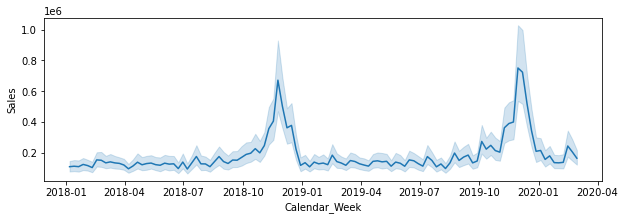

In [6]:
fig, ax = plt.subplots(figsize=(10, 3))
sns.lineplot(x="Calendar_Week", y="Sales", data=data, ax=ax)

<AxesSubplot:xlabel='Google_Impressions', ylabel='Sales'>

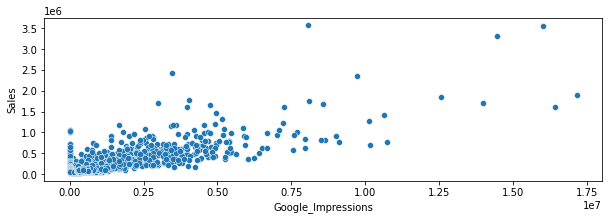

In [7]:
fig, ax = plt.subplots(figsize=(10, 3))
sns.scatterplot(x="Google_Impressions", y="Sales", data=data, ax=ax)

Let's compare the data from the first month to the last month, which happens to capture differences in transactions prior to and during the COVID-19 global pandemic.

## Profiling with whylogs

In [8]:
model_date = datetime.datetime(2020, 1, 1)
training_data = data[data["Calendar_Week"] < model_date]
test_data = data[data["Calendar_Week"] >= model_date]

In [9]:
session = get_or_create_session()

WARN: Missing config


In [10]:
profiles = []
profiles.append(session.log_dataframe(training_data, dataset_timestamp=model_date))
profiles.append(session.log_dataframe(test_data, dataset_timestamp=datetime.datetime.now()))

In [11]:
profiles

We can compare the data we'll use for training with that in early 2020.

In [12]:
# Training data profile summary
training_summary = profiles[0].flat_summary()["summary"]
training_summary

column   count  null_count  bool_count  numeric_count  \
0   Facebook_Impressions  2808.0         0.0         0.0         2808.0   
1          Overall_Views  2808.0         0.0         0.0         2808.0   
2               Division  2808.0         0.0         0.0            0.0   
3                  Sales  2808.0         0.0         0.0         2808.0   
4             Paid_Views  2808.0         0.0         0.0         2808.0   
5      Email_Impressions  2808.0         0.0         0.0         2808.0   
6     Google_Impressions  2808.0         0.0         0.0         2808.0   
7          Calendar_Week  2808.0         0.0         0.0            0.0   
8  Affiliate_Impressions  2808.0         0.0         0.0         2808.0   
9          Organic_Views  2808.0         0.0         0.0         2808.0   

            max           mean          min        stddev  nunique_numbers  \
0  7.558435e+06  269330.694088     29.00000  4.800746e+05           2793.0   
1  6.350570e+05   24357.878561      2.00000  4.901499e+04           2360.0   
2  0.000000e+00       0.000000      0.00000  0.000000e+00              0.0   
3  3.575430e+06  186838.814459  15436.00000  2.372908e+05           2788.0   
4  5.181900e+05   13424.596510      1.00000  2.974463e+04           2111.0   
5  5.160764e+06  755149.145825  40894.44732  6.095038e+05           2808.0   
6  1.715044e+07  898847.349715      7.00000  1.391820e+06           2678.0   
7  0.000000e+00       0.000000      0.00000  0.000000e+00              0.0   
8  1.757910e+05   23426.283476    910.00000  2.198081e+04           2715.0   
9  2.704530e+05   11406.093305      1.00000  2.218563e+04           2316.0   

   ...  ununique_str_upper  quantile_0.0000  quantile_0.0100  quantile_0.0500  \
0  ...                 0.0        29.000000      3092.000000      13177.00000   
1  ...                 0.0         2.000000        32.000000        159.00000   
2  ...                26.0              NaN              NaN              NaN   
3  ...                 0.0     15436.000000     25081.000000      44106.00000   
4  ...                 0.0         1.000000        17.000000        120.00000   
5  ...                 0.0     40894.449219     72250.273438     133280.15625   
6  ...                 0.0         7.000000        71.000000        262.00000   
7  ...                 0.0              NaN              NaN              NaN   
8  ...                 0.0       910.000000      1678.000000       3255.00000   
9  ...                 0.0         1.000000        28.000000        138.00000   

   quantile_0.2500  quantile_0.5000  quantile_0.7500  quantile_0.9500  \
0      55651.00000        122368.00         279480.0      1068670.000   
1        698.00000          5772.00          27299.0       106580.000   
2              NaN              NaN              NaN              NaN   
3      72069.00000        112454.00         201010.0       579378.000   
4        497.00000           982.00          14169.0        54496.000   
5     377753.90625        590957.25         955171.0      1884721.125   
6     164461.00000        490842.00        1042217.0      3213254.000   
7              NaN              NaN              NaN              NaN   
8       9202.00000         17048.00          28283.0        69402.000   
9        667.00000          3075.00          12929.0        47239.000   

   quantile_0.9900  quantile_1.0000  
0        2549912.0        7558435.0  
1         249012.0         635057.0  
2              NaN              NaN  
3         997182.0        3575430.0  
4         140432.0         518190.0  
5        3123674.5        5160763.5  
6        5978991.0       17150440.0  
7              NaN              NaN  
8         112846.0         175791.0  
9         100749.0         270453.0  

[10 rows x 32 columns]

In [13]:
# Test data profile summary
test_summary = profiles[1].flat_summary()["summary"]
test_summary

column  count  null_count  bool_count  numeric_count  \
0     Google_Impressions  243.0         0.0         0.0          243.0   
1   Facebook_Impressions  243.0         0.0         0.0          243.0   
2                  Sales  243.0         0.0         0.0          243.0   
3          Calendar_Week  243.0         0.0         0.0            0.0   
4  Affiliate_Impressions  243.0         0.0         0.0          243.0   
5             Paid_Views  243.0         0.0         0.0          243.0   
6      Email_Impressions  243.0         0.0         0.0          243.0   
7          Organic_Views  243.0         0.0         0.0          243.0   
8               Division  243.0         0.0         0.0            0.0   
9          Overall_Views  243.0         0.0         0.0          243.0   

           max           mean          min         stddev  nunique_numbers  \
0  4924815.000  739724.279835    156.00000  806022.000918            243.0   
1  1884146.000  266771.794239   6987.00000  263839.011975            243.0   
2  1181536.000  175069.012346  23012.00000  162280.683991            243.0   
3        0.000       0.000000      0.00000       0.000000              0.0   
4    79685.000   16955.390947   1139.00000   15712.996483            241.0   
5   195738.000   34384.152263    374.00000   35731.933116            242.0   
6  7317730.249  822449.835680  61334.57103  791161.059026            243.0   
7   198041.000   35884.152263   1917.00000   32322.531757            242.0   
8        0.000       0.000000      0.00000       0.000000              0.0   
9   381029.000   69847.102881   2767.00000   66124.495307            243.0   

   ...  ununique_str_upper  quantile_0.0000  quantile_0.0100  quantile_0.0500  \
0  ...                 0.0       156.000000       196.000000       531.000000   
1  ...                 0.0      6987.000000     13480.000000     33168.000000   
2  ...                 0.0     23012.000000     25043.000000     48057.000000   
3  ...                 0.0              NaN              NaN              NaN   
4  ...                 0.0      1139.000000      1529.000000      2498.000000   
5  ...                 0.0       374.000000      1033.000000      4106.000000   
6  ...                 0.0     61334.570312     65779.898438    137562.171875   
7  ...                 0.0      1917.000000      2064.000000      7516.000000   
8  ...                26.0              NaN              NaN              NaN   
9  ...                 0.0      2767.000000      2934.000000     12456.000000   

   quantile_0.2500  quantile_0.5000  quantile_0.7500  quantile_0.9500  \
0       274410.000      504923.0000      926291.0000        2542278.0   
1       103418.000      180094.0000      331702.0000         792423.0   
2        86953.000      124325.0000      206752.0000         430355.0   
3              NaN              NaN              NaN              NaN   
4         7719.000       12525.0000       20478.0000          59464.0   
5        13171.000       23623.0000       41052.0000         118075.0   
6       387119.625      580975.6875      997442.8125        2390848.0   
7        17112.000       26315.0000       44050.0000         104290.0   
8              NaN              NaN              NaN              NaN   
9        31996.000       49221.0000       82206.0000         227079.0   

   quantile_0.9900  quantile_1.0000  
0       4304549.00        4924815.0  
1       1073992.00        1884146.0  
2        968892.00        1181536.0  
3              NaN              NaN  
4         74730.00          79685.0  
5        183982.00         195738.0  
6       3884578.75        7317730.0  
7        173100.00         198041.0  
8              NaN              NaN  
9        337803.00         381029.0  

[10 rows x 32 columns]

## Dataset Drift in whylogs Data

We need to understand how the data changes between that used in training and test data. To do so, let's first view one of the many objects in the dataset profile provided by whylogs, a histogram for each feature tracked. We can then inspect the **Overall_Views** feature.

In [14]:
training_histograms = profiles[0].flat_summary()["hist"]
test_histograms = profiles[1].flat_summary()["hist"]

test_histograms["Overall_Views"]

{'bin_edges': [2767.0,
  15375.73460343,
  27984.46920686,
  40593.203810290004,
  53201.93841372,
  65810.67301715,
  78419.40762058001,
  91028.14222401001,
  103636.87682744,
  116245.61143087,
  128854.3460343,
  141463.08063773002,
  154071.81524116002,
  166680.54984459002,
  179289.28444802001,
  191898.01905145,
  204506.75365488,
  217115.48825831,
  229724.22286174,
  242332.95746517,
  254941.6920686,
  267550.42667203,
  280159.16127546004,
  292767.89587889,
  305376.63048232003,
  317985.36508575,
  330594.09968918003,
  343202.83429261,
  355811.56889604003,
  368420.30349947,
  381029.0381029],
 'counts': [17,
  32,
  42,
  40,
  26,
  18,
  15,
  13,
  8,
  3,
  5,
  7,
  0,
  0,
  1,
  2,
  0,
  2,
  0,
  3,
  1,
  1,
  2,
  0,
  1,
  0,
  2,
  1,
  0,
  1]}

While we plan to integrate convienient dataset shift visualization and analysis API soon, you are always able to access the attributes you need.

We will first define a custom range and bins, then utilize our access to the data sketches' probability mass function. We then visualize these values using Seaborn.

In [15]:
def get_custom_histogram_info(variable, n_bins):
    min_range = min(training_summary[training_summary["column"]==variable]["min"].values[0],
                    test_summary[test_summary["column"]==variable]["min"].values[0])
    max_range = max(training_summary[training_summary["column"]==variable]["max"].values[0],
                    test_summary[test_summary["column"]==variable]["max"].values[0])
    bins = range(int(min_range), int(max_range), int((max_range-min_range)/n_bins))

    training_counts = np.array(
        profiles[0].columns[variable].number_tracker.histogram.get_pmf(bins[:-1]))
    test_counts = np.array(
        profiles[1].columns[variable].number_tracker.histogram.get_pmf(bins[:-1]))
    
    return bins, training_counts, test_counts


def plot_distribution_shift(variable, n_bins):
    """Visualization for distribution shift"""
    bins, training_counts, test_counts = get_custom_histogram_info(variable, n_bins)

    fig, ax = plt.subplots(figsize=(10, 3))
    sns.histplot(x=bins, weights=training_counts, bins=n_bins, 
                 label="Training data", color="teal", alpha=0.7, ax=ax)
    sns.histplot(x=bins, weights=test_counts, bins=n_bins, 
                 label="Test data", color="gold", alpha=0.7, ax=ax)
    ax.legend()
    plt.show()

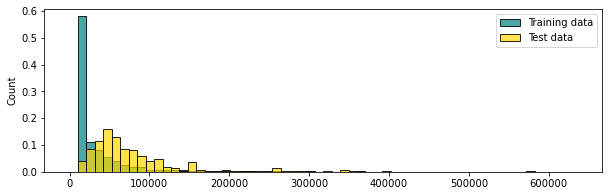

In [16]:
plot_distribution_shift("Overall_Views", n_bins=60)

While it is quite clear that the distribution in this case differs between the training and test dataset, we will likely need a quantitative measure. You can also use whylogs histogram metrics to calculate dataset shift using a number of metrics: Population Stability Index (PSI), Kolmogorov-Smirnov statistic, Kullback-Lebler divergence (or other f-divergences), and histogram intersection.

## Kullback-Lebler divergence

This score, often shortened to K-L divergence, is measure of how one probability distribution is different from a second, reference probability distribution. The K-L divergence can be interpreted as the average difference of the number of bits required for encoding samples of one distribution (*P*) using a code optimized for another (*Q*) rather than one optimized for *P*. KL divergence is not a true statistical metric of spread as it is not symmetric and does not satisfy the triangle inequality.

However, this value has become quite poplular and easy to calculate in Python. We'll use the implementation in `scikit-learn`.

In [17]:
from sklearn.metrics import mutual_info_score
    
def calculate_kl_divergence(variable, n_bins):
    _, training_counts, test_counts = get_custom_histogram_info(variable, n_bins)
    
    return mutual_info_score(training_counts, test_counts)

In [18]:
calculate_kl_divergence("Overall_Views", n_bins=60)

1.0302670122463595

## Histogram intersection metric

Our second metric is the histogram intersection score, which is an intuitive metric that measures the area of overlap between the two probability distributions. A histogram intersection score of 0.0 represents no overlap while a score of 1.0 represents identical distributions. This score requires discretized probability distributions and depends heavily on the choice of bin size and scale used.

In [19]:
def calculate_histogram_intersection(variable, n_bins):
    _, training_counts, test_counts = get_custom_histogram_info(variable, n_bins)
    
    result = 0
    for i in range(n_bins):
        result += min(training_counts[i], test_counts[i])
    return result

In [20]:
calculate_histogram_intersection("Overall_Views", n_bins=60)

0.4224833808167141

In [21]:
calculate_histogram_intersection("Sales", n_bins=60)

0.8290993985438428